# Categorical and Missing Data

In this session we will work with *airbnb* data. The goal is to predict the review scores rating. 

There are many entries (i.e rows) with missing attributes in our dataset. 

We will come around this issue by employing two approaches:
1. *Remove rows with missing values*
2. *Single imputation with median*

In [1]:
import pandas as pd
import numpy as np

from sklearn import preprocessing
from sklearn import linear_model
from sklearn.model_selection import cross_val_predict
from sklearn.impute import SimpleImputer

import matplotlib.pyplot as plt
import os

In [2]:
# Load data
if os.path.exists('data.csv'):
    df = pd.read_csv('data.csv')
else:
    df = pd.read_csv('http://data.insideairbnb.com/spain/comunidad-de-madrid/madrid/2018-01-17/data/listings.csv.gz', 
                      compression='gzip')
    df.to_csv('data.csv')

print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16313 entries, 0 to 16312
Data columns (total 97 columns):
Unnamed: 0                          16313 non-null int64
id                                  16313 non-null int64
listing_url                         16313 non-null object
scrape_id                           16313 non-null int64
last_scraped                        16313 non-null object
name                                16302 non-null object
summary                             15860 non-null object
space                               11798 non-null object
description                         16305 non-null object
experiences_offered                 16313 non-null object
neighborhood_overview               10343 non-null object
notes                               6734 non-null object
transit                             10186 non-null object
access                              9057 non-null object
interaction                         9196 non-null object
house_rules                

In [3]:
# We will focus on three attributes only
df = df[['host_response_time','host_response_rate','review_scores_rating']]

print(df.head())
print(df.host_response_time.unique())

  host_response_time host_response_rate  review_scores_rating
0       within a day                60%                  89.0
1     within an hour               100%                  91.0
2     within an hour               100%                  79.0
3     within an hour               100%                  90.0
4     within an hour               100%                  80.0
['within a day' 'within an hour' 'within a few hours' nan
 'a few days or more']


In [4]:
df.host_response_rate = df.host_response_rate.str.strip('%')
df.host_response_rate = pd.to_numeric(df.host_response_rate)

print(df.info(), '\n')
print(df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16313 entries, 0 to 16312
Data columns (total 3 columns):
host_response_time      13805 non-null object
host_response_rate      13805 non-null float64
review_scores_rating    13118 non-null float64
dtypes: float64(2), object(1)
memory usage: 382.4+ KB
None 

  host_response_time  host_response_rate  review_scores_rating
0       within a day                60.0                  89.0
1     within an hour               100.0                  91.0
2     within an hour               100.0                  79.0
3     within an hour               100.0                  90.0
4     within an hour               100.0                  80.0


### Removing rows with missing values

In [5]:
# Remove all rows with null values
df = df.dropna()

In [7]:
# Converting host_response_time attribute to categorical values.
# Two approaches:

# 1 - Encoding label encoder...
le = preprocessing.LabelEncoder()

arr = le.fit_transform(df.host_response_time)

df.host_response_time = arr

# 2 - ...OR alternative way 
df_label = df.apply(preprocessing.LabelEncoder().fit_transform)

In [8]:
print(arr)
df.head()

[1 3 3 ... 3 3 3]


,host_response_time,host_response_rate,review_scores_rating
0,1,60.0,89.0
1,3,100.0,91.0
2,3,100.0,79.0
3,3,100.0,90.0
4,3,100.0,80.0


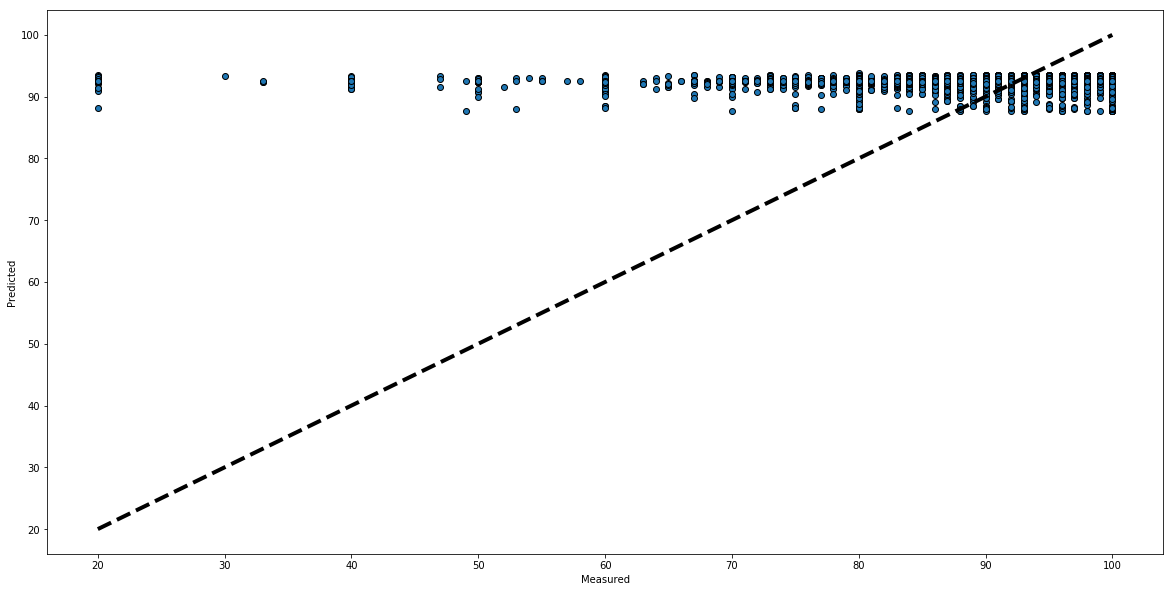

In [9]:
# Perform Linear Regression
lr = linear_model.LinearRegression()

# define labels and data (i.e y and X)
y = df.review_scores_rating
X = df.drop(columns='review_scores_rating')

predict = cross_val_predict(lr, X, y, cv=10)

fig, ax = plt.subplots(figsize=(20, 10))
ax.scatter(y, predict, edgecolors=(0, 0, 0))
ax.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=4)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
plt.show()


In [10]:
print(df.corr())

                      host_response_time  host_response_rate  \
host_response_time              1.000000            0.586101   
host_response_rate              0.586101            1.000000   
review_scores_rating            0.018660            0.066256   

                      review_scores_rating  
host_response_time                0.018660  
host_response_rate                0.066256  
review_scores_rating              1.000000  


### Single imputation with median.

In [11]:
# re-load the data
df = pd.read_csv('data.csv')

#select a subset of attributes 
df = df[['review_scores_accuracy','review_scores_cleanliness',
         'review_scores_checkin','review_scores_communication',
         'review_scores_location','review_scores_value',
         'review_scores_rating']]

print(df.isnull().sum())

review_scores_accuracy         3208
review_scores_cleanliness      3202
review_scores_checkin          3224
review_scores_communication    3209
review_scores_location         3230
review_scores_value            3231
review_scores_rating           3195
dtype: int64


In [12]:
# Drop rows where all are nan
df.dropna(axis=0, how='all', inplace=True)

print(df.isnull().sum())

review_scores_accuracy         14
review_scores_cleanliness       8
review_scores_checkin          30
review_scores_communication    15
review_scores_location         36
review_scores_value            37
review_scores_rating            1
dtype: int64


In [13]:
# Impute median value for original missing values and generate new dataframe
imputer = SimpleImputer(strategy='median')
df_imp = pd.DataFrame(imputer.fit_transform(df))

df_imp.columns = df.columns
df_imp.index = df.index

print(df_imp.isnull().sum())


review_scores_accuracy         0
review_scores_cleanliness      0
review_scores_checkin          0
review_scores_communication    0
review_scores_location         0
review_scores_value            0
review_scores_rating           0
dtype: int64


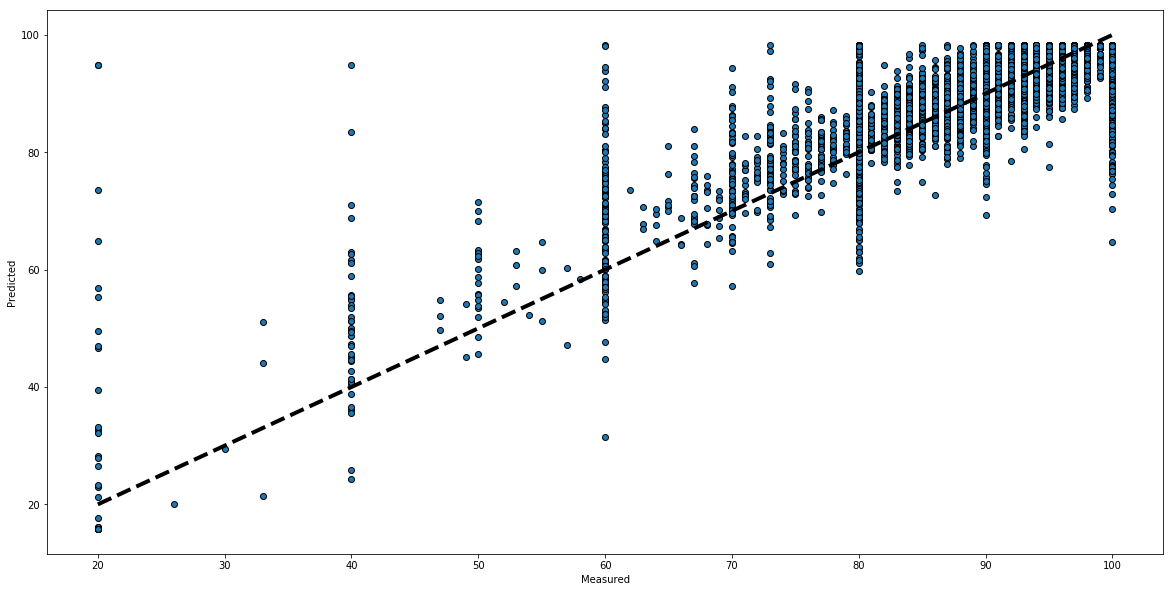

In [14]:
# Run Linear Regression
lr = linear_model.LinearRegression()

y = df_imp.review_scores_rating
X = df_imp.drop(columns='review_scores_rating')

predict = cross_val_predict(lr, X, y, cv=10)

fig, ax = plt.subplots(figsize=(20, 10))
ax.scatter(y, predict, edgecolors=(0, 0, 0))
ax.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=4)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
plt.show()


In [16]:
print(df.corr()['review_scores_rating'])

review_scores_accuracy         0.770071
review_scores_cleanliness      0.708366
review_scores_checkin          0.630672
review_scores_communication    0.663967
review_scores_location         0.424600
review_scores_value            0.799894
review_scores_rating           1.000000
Name: review_scores_rating, dtype: float64


In [17]:
print('thank you')

thank you
